# Lazada Review

### Persoalan merupakan data review produk di e commerce lazada, terdapat beberapa produk. Kolom yang ada (yang utama) adalah kolom teks, kategori, dan label rating.

### Persoalan dikategorikan sebagai persoalan multiclass berupa analisis sentimen (?)

In [ ]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/fwznbg/gemas/main/lazada-review/20191002-reviews.csv?token=ANMX7UV4G7W2RFTPXCCY5EDBLPATK'
df = pd.read_csv(url)

## Eksplorasi Dataset

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203787 entries, 0 to 203786
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   itemId          203787 non-null  int64  
 1   category        203787 non-null  object 
 2   name            203787 non-null  object 
 3   rating          203787 non-null  int64  
 4   originalRating  8 non-null       float64
 5   reviewTitle     23404 non-null   object 
 6   reviewContent   107029 non-null  object 
 7   likeCount       203787 non-null  int64  
 8   upVotes         203787 non-null  int64  
 9   downVotes       203787 non-null  int64  
 10  helpful         203787 non-null  bool   
 11  relevanceScore  203787 non-null  float64
 12  boughtDate      196680 non-null  object 
 13  clientType      203787 non-null  object 
 14  retrievedDate   203787 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 22.0+ MB
None


In [ ]:
df

,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02
1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,04 Apr 2018,androidApp,2019-10-02
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22 Sep 2017,androidApp,2019-10-02
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203782,9467899,shop-televisi-digital,Isharyanto S.,5,NaN,murah,barang bagus dengan harga kompetitif,6,6,0,True,24.63,22 Nov 2016,desktop,2019-10-02
203783,9467899,shop-televisi-digital,FIRLY B.,3,NaN,barang bagus dan sesuai pesanan,NaN,0,0,0,True,14.01,10 Apr 2018,androidApp,2019-10-02
203784,9548087,shop-televisi-digital,soni s.,5,NaN,NaN,NaN,0,0,0,True,15.63,04 Jan 2018,androidApp,2019-10-02
203785,9548767,shop-televisi-digital,Saidhusin H.,3,NaN,AKARI LED TV,Ok.thank lazada Pagi order sore barang nyampe ...,0,0,0,True,19.48,15 Nov 2016,mobile-app,2019-10-02


In [ ]:
#cek value counts dari category, persempit persoalan ke 1 kategori saja
print(df.category.value_counts())

beli-harddisk-eksternal    82223
jual-flash-drives          64754
beli-smart-tv              29765
shop-televisi-digital      21264
beli-laptop                 5781
Name: category, dtype: int64


In [ ]:
df[df['category'] == 'beli-harddisk-eksternal'].rating.value_counts()

5    66725
4     7378
1     3920
3     2871
2     1329
Name: rating, dtype: int64

In [ ]:
#kolom yang akan dihapus
del_cols = df.columns.to_list()
del_cols.remove('rating')
del_cols.remove('reviewContent')

In [ ]:
#pecah dataframenya
dfs = dict()
dfname = ['hd','laptop','stv','fd','tvd']
dfunique = df.category.unique()

for i in range(5):
  dfs[dfname[i]] = df[df['category'] == dfunique[i]].copy()
  #drop kolom tidak penting
  dfs[dfname[i]].drop(labels=del_cols,axis=1,inplace=True)
  #delete duplicates
  dfs[dfname[i]] = dfs[dfname[i]][~dfs[dfname[i]].duplicated()]
  #reset index
  dfs[dfname[i]] = dfs[dfname[i]].reset_index(drop=True)

## Data Harddisk

In [ ]:
#preview
dfs['hd']

,rating,reviewContent
0,5,bagus mantap dah sesui pesanan
1,4,"Bagus, sesuai foto"
2,5,okkkkk mantaaaaaaapppp ... goood
3,4,bagus sesuai
4,5,NaN
...,...,...
38337,5,Sip.untuk penyimpanan gak ada masalh pengirima...
38338,3,Readi nggak sist? Warnanya apa2 saja? Ini ori ...
38339,2,"Uang udh 10 hri blm di kembalikan, proses lama..."
38340,4,"barang sesuai gambar, kemasannya juga rapi,say..."


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print (dfs['hd'].sample(100))

       rating                                      reviewContent
23209       5    Gambar bagus dan soal harga murah di kelas nya.
27653       5                         mantab deh recomended bgt👍
10189       4  Pengiriman sangat cepat, tp untuk memutar flim...
26972       5    datang tepat waktu,sesuai deskripsi,semoga awet
31271       5  pengiriman sangat cepat pesen Tgl 8 di kirim t...
3683        5                                         Thank you!
29306       1  pesan 2 pcs,di buka barang nya cuma 1 yg datan...
34320       5                       bagusssmantaap.. real pic...
1452        5      terima kasih paket sudah diterima dengan baik
24002       5          pesanan cepat sampai barang lumayan bagus
4147        5  该产品已到达我家，谢谢，因为我真的需要这个来保存外部硬盘或powerbank ..建立质量好...
19114       5  pengiriman cepat , packing rapih , recommed se...
16842       5     brg sesuai pesanan dan bonus tepat hardisk thx
16408       3                  Great, it's like what I expected.
36103       5  Ga kebaca 

## Feature Engineering

In [ ]:
import re, nltk
'''
NLP Feature Engineering Functions

source : https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/
'''

##----------FEATURE EXTRACTION/GENERATION----------##

#simply the length of the entire text
def count_chars(text):
    try:
        return len(text)
    except:
        return 0

#return number of words contain in the text
def count_words(text):
    try:
        return len(text.split())
    except:
        return 0

#return number of capital characters contained in the text
def count_capital_chars(text):
    try:
        count=0
        for i in text:
            if i.isupper():
                count+=1
        return count
    except:
        return 0

'''
Uppercase/capital-related function

all --> all letter in the word are capital
any --> check wether any letter in the word is capital
begin --> check wether the word starts in capital letter

'''
def contain_capital(word):
    try:
        return not(word.islower())
    except:
        return False

def begins_in_capital(word):
    try:
        return word[0].isupper()
    except:
        return False

capital_function = {
    'all' : str.isupper,
    'any' : contain_capital,
    'begin' : begins_in_capital
}

#return the number of words containing capital letter as described by the how argument
def count_capital_words(text,how='all'):
    try:
        return sum(map(capital_function[how],text.split()))
    except:
        return 0

#returns the number of punctuation contained in the text
def count_punctuations(text):
    try:
        punctuations='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        d=dict()
        for i in punctuations:
            d[str(i)+' count']=text.count(i)
        return d
    except:
        return dict()

def count_punctuations_(text,punct):
    return text.count(punct)

#return number of words in double quote
def count_words_in_double_quotes(text):
    try:
        x = re.findall(r'"([^"]*)"', text)
        count=0
        if x is None:
            return 0
        else:
            for i in x:
                t=i[1:-1]
                count+=count_words(t)
            return count
    except:
        return 0

#return number of words in single quote
def count_words_in_single_quotes(text):
    try:
        x = re.findall(r"'([^']*)'", text)
        count=0
        if x is None:
            return 0
        else:
            for i in x:
                t=i[1:-1]
                count+=count_words(t)
            return count
    except:
        return 0

#return number of sentences
def count_sent(text):
    try:
        return len(nltk.sent_tokenize(text))
    except:
        return 0

#return number of unique words
#example : "I love you the way you love me" returns 5 (you, love, and me appear more than once)
def count_unique_words(text):
    try:
        return len(set(text.split()))
    except:
        return 0

#return number of hashtags contained in the text
#  *this maybe helpful in handling social media status/post
def count_htags(text):
    try:
        x = re.findall(r'#\w+', text)
        return len(x)
    except:
        return 0 

#return number of mentions contained in the text
#  *this maybe helpful in handling social media status/post
def count_mentions(text):
    try:
        x = re.findall(r'@\w+', text)
        return len(x)
    except:
        return 0

'''
Stop words related functions

source : https://github.com/masdevid/ID-Stopwords/blob/master/id.stopwords.02.01.2016.txt

source also similar with nltk.corpus.stopwords.words('indonesian')
'''

stopwords = ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berkenaan', 'berlainan', 'berlalu', 'berlangsung', 'berlebihan', 'bermacam', 'bermacam-macam', 'bermaksud', 'bermula', 'bersama', 'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya', 'berturut', 'berturut-turut', 'bertutur', 'berujar', 'berupa', 'besar', 'betul', 'betulkah', 'biasa', 'biasanya', 'bila', 'bilakah', 'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah', 'buat', 'bukan', 'bukankah', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya', 'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 'dapat', 'dari', 'daripada', 'datang', 'dekat', 'demi', 'demikian', 'demikianlah', 'dengan', 'depan', 'di', 'dia', 'diakhiri', 'diakhirinya', 'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 'diberikannya', 'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 'digunakan', 'diibaratkan', 'diibaratkannya', 'diingat', 'diingatkan', 'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan', 'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 'dikira', 'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 'dimaksudkannya', 'dimaksudnya', 'diminta', 'dimintai', 'dimisalkan', 'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan', 'dini', 'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 'diperkirakan', 'diperlihatkan', 'diperlukan', 'diperlukannya', 'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya', 'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 'disinilah', 'ditambahkan', 'ditandaskan', 'ditanya', 'ditanyai', 'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk', 'ditunjuki', 'ditunjukkan', 'ditunjukkannya', 'ditunjuknya', 'dituturkan', 'dituturkannya', 'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 'dua', 'dulu', 'empat', 'enggak', 'enggaknya', 'entah', 'entahlah', 'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 'harus', 'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 'hingga', 'ia', 'ialah', 'ibarat', 'ibaratkan', 'ibaratnya', 'ibu', 'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan', 'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jadilah', 'jadinya', 'jangan', 'jangankan', 'janganlah', 'jauh', 'jawab', 'jawaban', 'jawabnya', 'jelas', 'jelaskan', 'jelaslah', 'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 'kala', 'kalau', 'kalaulah', 'kalaupun', 'kalian', 'kami', 'kamilah', 'kamu', 'kamulah', 'kan', 'kapan', 'kapankah', 'kapanpun', 'karena', 'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah', 'katanya', 'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya', 'keinginan', 'kelamaan', 'kelihatan', 'kelihatannya', 'kelima', 'keluar', 'kembali', 'kemudian', 'kemungkinan', 'kemungkinannya', 'kenapa', 'kepada', 'kepadanya', 'kesampaian', 'keseluruhan', 'keseluruhannya', 'keterlaluan', 'ketika', 'khususnya', 'kini', 'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 'kurang', 'lagi', 'lagian', 'lah', 'lain', 'lainnya', 'lalu', 'lama', 'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat', 'lima', 'luar', 'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 'mampukah', 'mana', 'manakala', 'manalagi', 'masa', 'masalah', 'masalahnya', 'masih', 'masihkah', 'masing', 'masing-masing', 'mau', 'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya', 'memang', 'memastikan', 'memberi', 'memberikan', 'membuat', 'memerlukan', 'memihak', 'meminta', 'memintakan', 'memisalkan', 'memperbuat', 'mempergunakan', 'memperkirakan', 'memperlihatkan', 'mempersiapkan', 'mempersoalkan', 'mempertanyakan', 'mempunyai', 'memulai', 'memungkinkan', 'menaiki', 'menambahkan', 'menandaskan', 'menanti', 'menanti-nanti', 'menantikan', 'menanya', 'menanyai', 'menanyakan', 'mendapat', 'mendapatkan', 'mendatang', 'mendatangi', 'mendatangkan', 'menegaskan', 'mengakhiri', 'mengapa', 'mengatakan', 'mengatakannya', 'mengenai', 'mengerjakan', 'mengetahui', 'menggunakan', 'menghendaki', 'mengibaratkan', 'mengibaratkannya', 'mengingat', 'mengingatkan', 'menginginkan', 'mengira', 'mengucapkan', 'mengucapkannya', 'mengungkapkan', 'menjadi', 'menjawab', 'menjelaskan', 'menuju', 'menunjuk', 'menunjuki', 'menunjukkan', 'menunjuknya', 'menurut', 'menuturkan', 'menyampaikan', 'menyangkut', 'menyatakan', 'menyebutkan', 'menyeluruh', 'menyiapkan', 'merasa', 'mereka', 'merekalah', 'merupakan', 'meski', 'meskipun', 'meyakini', 'meyakinkan', 'minta', 'mirip', 'misal', 'misalkan', 'misalnya', 'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 'mungkinkah', 'nah', 'naik', 'namun', 'nanti', 'nantinya', 'nyaris', 'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya', 'pak', 'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 'pentingnya', 'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 'pernah', 'persoalan', 'pertama', 'pertama-tama', 'pertanyaan', 'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun', 'punya', 'rasa', 'rasanya', 'rata', 'rupanya', 'saat', 'saatnya', 'saja', 'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 'sampai-sampai', 'sampaikan', 'sana', 'sangat', 'sangatlah', 'satu', 'saya', 'sayalah', 'se', 'sebab', 'sebabnya', 'sebagai', 'sebagaimana', 'sebagainya', 'sebagian', 'sebaik', 'sebaik-baiknya', 'sebaiknya', 'sebaliknya', 'sebanyak', 'sebegini', 'sebegitu', 'sebelum', 'sebelumnya', 'sebenarnya', 'seberapa', 'sebesar', 'sebetulnya', 'sebisanya', 'sebuah', 'sebut', 'sebutlah', 'sebutnya', 'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit', 'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 'sehingga', 'seingat', 'sejak', 'sejauh', 'sejenak', 'sejumlah', 'sekadar', 'sekadarnya', 'sekali', 'sekali-kali', 'sekalian', 'sekaligus', 'sekalipun', 'sekarang', 'sekarang', 'sekecil', 'seketika', 'sekiranya', 'sekitar', 'sekitarnya', 'sekurang-kurangnya', 'sekurangnya', 'sela', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya', 'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 'semakin', 'semampu', 'semampunya', 'semasa', 'semasih', 'semata', 'semata-mata', 'semaunya', 'sementara', 'semisal', 'semisalnya', 'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian', 'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 'sepantasnya', 'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 'sepihak', 'sering', 'seringnya', 'serta', 'serupa', 'sesaat', 'sesama', 'sesampai', 'sesegera', 'sesekali', 'seseorang', 'sesuatu', 'sesuatunya', 'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap', 'setiba', 'setibanya', 'setidak-tidaknya', 'setidaknya', 'setinggi', 'seusai', 'sewaktu', 'siap', 'siapa', 'siapakah', 'siapapun', 'sini', 'sinilah', 'soal', 'soalnya', 'suatu', 'sudah', 'sudahkah', 'sudahlah', 'supaya', 'tadi', 'tadinya', 'tahu', 'tahun', 'tak', 'tambah', 'tambahnya', 'tampak', 'tampaknya', 'tandas', 'tandasnya', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi', 'tegas', 'tegasnya', 'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 'tentunya', 'tepat', 'terakhir', 'terasa', 'terbanyak', 'terdahulu', 'terdapat', 'terdiri', 'terhadap', 'terhadapnya', 'teringat', 'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira', 'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersampaikan', 'tersebut', 'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama', 'tetap', 'tetapi', 'tiap', 'tiba', 'tiba-tiba', 'tidak', 'tidakkah', 'tidaklah', 'tiga', 'tinggi', 'toh', 'tunjuk', 'turut', 'tutur', 'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umum', 'umumnya', 'ungkap', 'ungkapnya', 'untuk', 'usah', 'usai', 'waduh', 'wah', 'wahai', 'waktu', 'waktunya', 'walau', 'walaupun', 'wong', 'yaitu', 'yakin', 'yakni', 'yang']

#returns number of stopwords appear in the text
def count_stopwords(text):
    try:
        word_tokens = nltk.word_tokenize(text)
        appeared_stopwords = [w for w in word_tokens if w in stopwords]
        return len(appeared_stopwords)
    except:
        return 0

#returns the ration between the character counts and the word counts
def average_word_length(text):
    try:
        return count_chars(text)/count_words(text)
    except:
        return 0

#returns the ratio between the word counts and the sentence counts
def average_sentence_length(text):
    try:
        return count_words(text)/count_sent(text)
    except:
        return 0

#return the ration between the unique word counts and the word counts
def unique_vs_words(text):
    try:
        return count_unique_words(text)/count_words(text)
    except:
        return 0

#return the ratio between the stopwords count and the word counts
def stopwords_vs_words(text):
    try:
        return count_stopwords(text)/count_words(text)
    except:
        return 0


'''
Generate all feature

returning dataframe
'''

import pandas as pd

def generate_all(df,name=None):
    if name == None:
      name = ""
    else:
      name = "_" + name
    res = pd.DataFrame()
    res['count_chars' + name] = df.apply(count_chars)
    res['count_words' + name] = df.apply(count_words)
    res['count_capital_chars' + name] = df.apply(count_capital_chars)

    res['count_capital_words_all' + name] = df.apply(lambda x: count_capital_words(x,'all'))
    res['count_capital_words_any' + name] = df.apply(lambda x: count_capital_words(x,'any'))
    res['count_capital_words_begin' + name] = df.apply(lambda x: count_capital_words(x,'begin'))

    res['count_words_in_double_quotes' + name] = df.apply(count_words_in_double_quotes)
    res['count_words_in_single_quotes' + name] = df.apply(count_words_in_single_quotes)

    res['count_sent' + name] = df.apply(count_sent)
    res['count_unique_words' + name] = df.apply(count_unique_words)

    res['count_htags' + name] = df.apply(count_htags)
    res['count_mentions' + name] = df.apply(count_mentions)
    res['count_stopwords' + name] = df.apply(count_stopwords)

    res['average_word_length' + name] = df.apply(average_word_length)
    res['average_sentence_length' + name] = df.apply(average_sentence_length)
    res['unique_vs_words' + name] = df.apply(unique_vs_words)
    res['stopwords_vs_words' + name] = df.apply(stopwords_vs_words)

    return res

In [ ]:
dfshd_feat = generate_all(dfs['hd']['reviewContent'],'hd')

In [ ]:
dfshd_feat

,count_chars_hd,count_words_hd,count_capital_chars_hd,count_capital_words_all_hd,count_capital_words_any_hd,count_capital_words_begin_hd,count_words_in_double_quotes_hd,count_words_in_single_quotes_hd,count_sent_hd,count_unique_words_hd,count_htags_hd,count_mentions_hd,count_stopwords_hd,average_word_length_hd,average_sentence_length_hd,unique_vs_words_hd,stopwords_vs_words_hd
0,31,5,0,0,0,0,0,0,0,5,0,0,0,6.200000,0,1.0,0.0
1,18,3,1,0,1,1,0,0,0,3,0,0,0,6.000000,0,1.0,0.0
2,32,4,0,0,1,0,0,0,0,4,0,0,0,8.000000,0,1.0,0.0
3,12,2,0,0,0,0,0,0,0,2,0,0,0,6.000000,0,1.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38337,59,8,1,0,1,1,0,0,0,8,0,0,0,7.375000,0,1.0,0.0
38338,75,14,3,0,3,3,0,0,0,14,0,0,0,5.357143,0,1.0,0.0
38339,57,11,1,0,2,1,0,0,0,11,0,0,0,5.181818,0,1.0,0.0
38340,93,12,0,0,0,0,0,0,0,12,0,0,0,7.750000,0,1.0,0.0


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 8 12 14 16] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


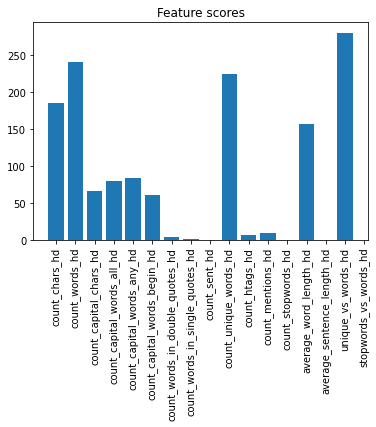

In [ ]:
#ngetes aja latihan2

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

#memakai visualisasi
score , pvalue = f_classif(dfshd_feat,dfs['hd']['rating'])

plt.bar(x=dfshd_feat.columns.to_list(),height=score)
plt.title("Feature scores")
plt.xticks(rotation=90)
plt.show()

## Cleaning/Preprocessing

### Remove Noises

In [ ]:
#terdapat beberapa hipotesis dari data
#1. kalimat cenderung informal
#2. banyak terjadi kesalahan penulisan (typo)
#3. upper case atau huruf kapital cenderung tidak terlalu penting
#4. ada emoji
#5. ada karakter2 aneh

##------PREPROCESSING------##

#remove null
dfs['hd'].dropna(axis=0,inplace=True)

#bikin colom reviewclean
dfs['hd']['review_clean'] = dfs['hd']['reviewContent']

#case folding
dfs['hd']['review_clean'] = dfs['hd'].review_clean.str.lower()

#trim space
dfs['hd']['review_clean'] = dfs['hd'].review_clean.str.strip()

In [ ]:
#normalisasi pengulangan huruf

import re

def normalize_teriak(text):
    return re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', text)

In [ ]:
dfs['hd']['review_clean'] = dfs['hd'].review_clean.apply(normalize_teriak)

In [ ]:
#remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

In [ ]:
#belum semua emoji
dfs['hd']['review_clean'] = dfs['hd'].review_clean.apply(remove_emoji)

In [ ]:
#remove punctuation
import string

#remove punctuation/tanda baca

punct = "["
for s in string.punctuation:
  punct += s
punct += "]"

In [ ]:
#remove digit, remove punctuation, remove spaces
dfs['hd']['review_clean'] = dfs['hd'].review_clean.str.replace(r'\d', ' ')
dfs['hd']['review_clean'] = dfs['hd'].review_clean.str.replace(punct, ' ')
dfs['hd']['review_clean'] = dfs['hd'].review_clean.str.replace(r'\s+', ' ')
dfs['hd']['review_clean'] = dfs['hd'].review_clean.str.strip()

In [ ]:
#remove row with 
dfs['hd'] = dfs['hd'][~dfs['hd'].review_clean.str.contains(r'[^\sa-zA-Z]')]

In [ ]:
#removing stop words sederhana saja
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

sw = stopwords.words('indonesian')

def remove_stopword(text):
  tokens = text.split()
  tokens = [t for t in tokens if t not in sw]
  return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import time

start = time.time()
dfs['hd']['review_clean'] = dfs['hd'].review_clean.apply(remove_stopword)
timelapse = time.time() - start
print("Time : " + str(timelapse) + " s")

Time : 5.289215087890625 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
dfs['hd'].sample(10)

,rating,reviewContent,review_clean
32117,5,"Ntap souuul~ Harga emang gak boong, cakep dah ...",ntap soul harga emang gak boong cakep dah poko...
19846,5,"thanks barang sesuai pesanan, pengiriman cepat...",thanks barang sesuai pesanan pengiriman cepat ...
9214,5,mantabbbb....,mantab
17762,5,"Buat yang nanya port nya, ada 1 USB port dan 2...",nanya port nya usb port hdmi port keren sehari...
22662,5,"Kualitas produk baik, pengirimannya cepat",kualitas produk pengirimannya cepat
26080,5,"Nice one tv nya , makasih lazada , kurirnya ba...",nice one tv nya makasih lazada kurirnya bagus ...
4527,1,"Barang kw di jual rugi saya beli ,,kalau mau j...",barang kw jual rugi beli jual barang jual harg...
9824,2,awal dateng si oke selepas update windows kok ...,dateng si oke selepas update windows trouble l...
21779,5,recommended bangettt. barang ok packing mantaff,recommended banget barang ok packing mantaff
3840,5,Respon seller bagus dan cepat,respon seller bagus cepat


In [ ]:
dfs['hd'] = dfs['hd'][dfs['hd'].review_clean.str.contains(r'[\w\s\d]')]
# dfs['hd'][dfs['hd'].review_clean.str.len() == 0]

### Normalization

In [ ]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/fwznbg/gemas/main/kamus_alay_nasigoreng/kamus_alay_nasigoreng.csv?token=ANMX7UVLDNBKTTZPVDJEHTTBLPXBY')

In [ ]:
kamus_alay.index = kamus_alay['Unnamed: 0'].values
kamus_alay = kamus_alay['value']

In [ ]:
def normalize_slang(text, kamus_alay=kamus_alay):
    text = text.split()
    
    for i in range(len(text)):
        if(text[i] in kamus_alay.index):
            text[i] = kamus_alay[text[i]]
     
    text = " ".join(text)
    return text

In [ ]:
start = time.time()
dfs['hd']['review_clean'] = dfs['hd'].review_clean.apply(normalize_slang)
print("Time :", time.time()-start, "s")

Time : 0.7468905448913574 s


In [ ]:
dfs['hd'].review_clean.sample(10)

25745    mantap puas banget produk pintar televisi nya ...
4690                         good seller salah kirim warna
37876                minggu ditunggu packingnya bagus rapi
3828                                      discount juragan
7262                                    mantap paking aman
18628                                               mantap
12279                                               mantap
36259          barang dikirim barang harganya murah kecewa
19194    jooss pokoknya pesan malam siangnya sampai ses...
30653    alhamdulillah sesuai pesanan terima kasih laza...
Name: review_clean, dtype: object

## Transformation

In [ ]:
!pip install nltk
!pip install gensim

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# from nltk.tokenize import sent_tokenize, word_tokenize

import gensim
from gensim.models import Word2Vec

### Count Vectorizer and TfIdf

In [ ]:
#tokenize for word2vec
dfs['hd']['review_clean_token'] = dfs['hd']['review_clean'].str.split()

## Prepare for Unbalanced Dataset

In [ ]:
dfs['hd'].rating.value_counts()

5    28839
4     4048
1     2617
3     1631
2      815
Name: rating, dtype: int64

In [ ]:
dfs['hd'].loc[dfs['hd']['rating'] == 5,'rating5'] = 1
dfs['hd'].loc[dfs['hd']['rating'] != 5,'rating5'] = 0

## Modeling

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
def make_pipeline(model,df,xcol,ycol,vect):
  X_train, X_test, y_train, y_test = train_test_split(df[xcol], df[ycol], test_size=0.2, random_state=42)
  X_train_vect = vect.fit_transform(X_train)
  X_test_vect = vect.transform(X_test)
  model.fit(X_train_vect.toarray(),y_train)
  y_pred_test = model.predict(X_test_vect)
  print(classification_report(y_test,y_pred_test))
  
  return model, vect, X_train_vect, X_test_vect, y_train, y_test

### Multinomial NB

In [ ]:
from sklearn import naive_bayes

#### Multinomial NB CountVect/Tfidf, Unstemmed/Unlemmatized

In [ ]:
def nb_pipeline(nb,df,xcol,ycol,vect):
  X_train, X_test, y_train, y_test = train_test_split(df[xcol], df[ycol], test_size=0.2, random_state=42)
  X_train_vect = vect.fit_transform(X_train)
  X_test_vect = vect.transform(X_test)
  nb.fit(X_train_vect.toarray(),y_train)
  y_pred_test = nb.predict(X_test_vect)
  print(classification_report(y_test,y_pred_test))
  
  return nb, vect, X_train_vect, X_test_vect, y_train, y_test

In [ ]:
#count vectorizer
mnb_unstem_cnt, cntvect_unstem, X_train_cntvect_1, X_test_cntvect_1, y_train_1, y_test_1 = nb_pipeline(naive_bayes.MultinomialNB(),
                                                                               dfs['hd'],
                                                                               'review_clean',
                                                                               'rating5',
                                                                               CountVectorizer())

              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57      1794
         1.0       0.86      0.92      0.89      5796

    accuracy                           0.82      7590
   macro avg       0.76      0.71      0.73      7590
weighted avg       0.81      0.82      0.81      7590



In [ ]:
#tfidf
mnb_unstem_tfidf, tfidfvect_unstem, X_train_tfidfvect_2, X_test_tfidfvect_2, y_train_2, y_test_2 = nb_pipeline(naive_bayes.MultinomialNB(),
                                                                               dfs['hd'],
                                                                               'review_clean',
                                                                               'rating5',
                                                                               TfidfVectorizer())

              precision    recall  f1-score   support

         0.0       0.79      0.26      0.39      1794
         1.0       0.81      0.98      0.89      5796

    accuracy                           0.81      7590
   macro avg       0.80      0.62      0.64      7590
weighted avg       0.80      0.81      0.77      7590



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators' : [100,200,300]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, refit = True, verbose = 3)

In [ ]:
rf_grid_cnt, rfcntvect_unstem, X_train_cntvect_5, X_test_cntvect_5, y_train_5, y_test_5 = make_pipeline(rf_grid,
                                                                                                        dfs['hd'],
                                                                                                        'review_clean',
                                                                                                        'rating5',
                                                                                                        CountVectorizer())

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=100, score=0.798, total= 4.3min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.806, total= 4.4min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.7min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.811, total= 4.4min
[CV] n_estimators=100 ................................................
[CV] .................... n_estimators=100, score=0.800, total= 4.3min
[CV] n_estimators=100 ................................................
[CV] .................... n_estimators=100, score=0.799, total= 6.1min
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.800, total=13.7min
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.809, total=10.4min
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.810, total= 8.8min
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.802, total=12.9min
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 163.3min finished


              precision    recall  f1-score   support

         0.0       0.71      0.41      0.52      1794
         1.0       0.84      0.95      0.89      5796

    accuracy                           0.82      7590
   macro avg       0.77      0.68      0.70      7590
weighted avg       0.81      0.82      0.80      7590



In [ ]:
rf_grid_tfidf, rftfidfvect_unstem, X_train_tfidfvect_6, X_test_tfidfvect_6, y_train_6, y_test_6 = make_pipeline(rf_grid,
                                                                                                        dfs['hd'],
                                                                                                        'review_clean',
                                                                                                        'rating5',
                                                                                                        TfidfVectorizer())

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=100, score=0.797, total= 8.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.0min remaining:    0.0s


[CV] n_estimators=100 ................................................
[CV] .................... n_estimators=100, score=0.809, total= 6.1min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.0min remaining:    0.0s


[CV] .................... n_estimators=100, score=0.808, total= 5.2min
[CV] n_estimators=100 ................................................
[CV] .................... n_estimators=100, score=0.801, total= 5.5min
[CV] n_estimators=100 ................................................
[CV] .................... n_estimators=100, score=0.803, total= 5.8min
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.800, total=15.0min
[CV] n_estimators=200 ................................................


### SVM

In [ ]:
from sklearn.svm import SVC

param_grid_svc = {
    'kernel' : ['rbf','poly']
}

svc_grid = GridSearchCV(SVC(random_state=42), param_grid_svc, refit = True, verbose = 3)

In [ ]:
def svc_pipeline(df,xcol,ycol,vect):
  X_train, X_test, y_train, y_test = train_test_split(df[xcol], df[ycol], test_size=0.2, random_state=42)
  X_train_vect = vect.fit_transform(X_train)
  X_test_vect = vect.transform(X_test)

  svc_grid = GridSearchCV(SVC(random_state=42), {'kernel' : ['rbf','poly']}, refit = True, verbose = 3)

  start = time.time()
  svc_grid.fit(X_train_vect,y_train)
  print("Time :", time.time()-start, "s")

  y_pred_test = svc_grid.predict(X_test_vect)
  print(classification_report(y_test,y_pred_test))

  return svc_grid, vect, X_train_vect, X_test_vect, y_train, y_test

#### SVM count

In [ ]:
svc_grid_cnt, svmcntvect_unstem, X_train_cntvect_3, X_test_cntvect_3, y_train_3, y_test_3 = svc_pipeline(dfs['hd'],
                                                                                                         'review_clean',
                                                                                                         'rating5',
                                                                                                         CountVectorizer())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... kernel=rbf, score=0.799, total= 2.5min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.803, total= 2.6min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.810, total= 2.6min
[CV] kernel=rbf ......................................................
[CV] .......................... kernel=rbf, score=0.803, total= 2.7min
[CV] kernel=rbf ......................................................
[CV] .......................... kernel=rbf, score=0.806, total= 2.6min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.772, total= 3.6min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.770, total= 3.7min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.771, total= 3.6min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.772, total= 3.7min
[CV] kernel=poly .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 31.2min finished


Time : 2122.0006675720215 s
              precision    recall  f1-score   support

         0.0       0.76      0.32      0.45      1794
         1.0       0.82      0.97      0.89      5796

    accuracy                           0.82      7590
   macro avg       0.79      0.64      0.67      7590
weighted avg       0.81      0.82      0.78      7590



#### SVC Tfidf

In [ ]:
svc_grid_tfidf, svmtfidfvect_unstem, X_train_tfidfvect_4, X_test_tfidfvect_4, y_train_4, y_test_4 = svc_pipeline(dfs['hd'],
                                                                                                         'review_clean',
                                                                                                         'rating5',
                                                                                                         TfidfVectorizer())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... kernel=rbf, score=0.813, total= 2.7min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.812, total= 2.7min
[CV] kernel=rbf ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s


[CV] .......................... kernel=rbf, score=0.819, total= 2.7min
[CV] kernel=rbf ......................................................
[CV] .......................... kernel=rbf, score=0.819, total= 2.8min
[CV] kernel=rbf ......................................................
[CV] .......................... kernel=rbf, score=0.811, total= 2.7min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.779, total= 3.1min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.780, total= 3.1min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.783, total= 3.0min
[CV] kernel=poly .....................................................
[CV] ......................... kernel=poly, score=0.782, total= 3.1min
[CV] kernel=poly .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.2min finished


Time : 2013.8159277439117 s
              precision    recall  f1-score   support

         0.0       0.75      0.40      0.52      1794
         1.0       0.84      0.96      0.89      5796

    accuracy                           0.83      7590
   macro avg       0.79      0.68      0.71      7590
weighted avg       0.82      0.83      0.81      7590



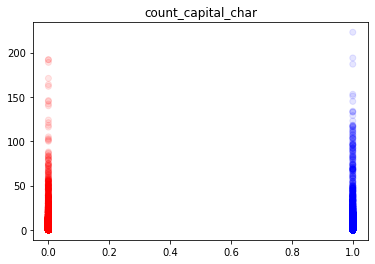

deskripsi count_capital_char untuk non hate speech
count    7608.000000
mean        6.409700
std        11.278633
min         0.000000
25%         1.000000
50%         3.000000
75%         8.000000
max       192.000000
Name: count_capital_char, dtype: float64

deskripsi count_capital_char untuk hate speech
count    5561.000000
mean        7.497393
std        14.814684
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       223.000000
Name: count_capital_char, dtype: float64


In [ ]:
analysis_feature_extraction('count_capital_char')